In [1]:
%display latex

# Charts on $\mathbb{S}^2$ 
This notebook presents an abriged version of [a SageManifold example](https://nbviewer.jupyter.org/github/sagemanifolds/SageManifolds/blob/master/Notebooks/SM_sphere_S2.ipynb), with some of my own contributions in place.

It was created to familiarise myself further with operations on $\mathbb{S}^2$ in preparation for calculating sundial projections.

<!--BEGIN TOC-->
## Table of Contents
1. [Stereographic projections](#0-Stereographic-projections)
    1. [Transition map](#0-Transition-map)
    2. [Plotting $(W,(x', y'))$](#0-Plotting-$(W,(x',-y'))$)
2. [Spherical coordinates](#0-Spherical-coordinates)
    1. [Transition maps](#0-Transition-maps)
    2. [Plotting](#0-Plotting)
3. [Points on $\mathbb{S}^2$](#0-Points-on-$\mathbb{S}^2$)
4. [Embedding $\mathbb{S}^2$ into $\mathbb{R}^3$](#0-Embedding-$\mathbb{S}^2$-into-$\mathbb{R}^3$)
    1. [Plotting](#0-Plotting)

<!--END TOC-->

## Stereographic projections <a name="0-Stereographic-projections"></a>
We start by defining $\mathbb{S}^2$ as a 2-dimensional differentiable manifold over $\mathbb{R}$:

In [2]:
S2 = Manifold(2, "S^2", latex_name=r"\mathbb{S}^2")
S2

2-dimensional differentiable manifold S^2

The sphere cannot be covered by a single chart, but instead requires at least two; for stereographic projections, we may consider the view from the north and south poles.

To represent these, we'll define two open-subsets of $\mathbb{S}^2$, namely

$$
U := \mathbb{S}^2 \backslash \{N\},
$$

and

$$
V := \mathbb{S}^2 \backslash \{S\},
$$

where $N$ and $S$ are antipodal north and south poles respectively, which will have coordinates $(0,0)$ in charts on $V$ and $U$ respectively.

In [3]:
U = S2.open_subset("U")
V = S2.open_subset("V")

S2.declare_union(U, V)

We declare `S2` as the union of `U` and `V`; this tells SageManifold that $\mathbb{S}^2 \sim U \cup V $.

Next we will define a chart on $U$ and $V$, where $V$ will used primed coordinates:

In [4]:
stereo_n.<x, y> = U.chart()
stereo_s.<xp, yp> = V.chart("xp:x' yp:y'")

stereo_n, stereo_s

(Chart (U, (x, y)), Chart (V, (xp, yp)))

### Transition map <a name="0-Transition-map"></a>

We haven't yet restricted $U$ or $V$ to their domains; however, we can do this in the transition map:

In [5]:
stereo_n2s = stereo_n.transition_map(
    stereo_s,
    (x / (x^2 + y^2), y / (x^2 + y^2)),
    intersection_name="W",
    restrictions1= x^2 + y^2 != 0,
    restrictions2= xp^2 + yp^2 != 0
)

stereo_n2s.display()

xp = x/(x^2 + y^2)
yp = y/(x^2 + y^2)

Here, $W$ is the subset $W \sim U \cap V$. Our conditions (`restrictions`) define $W$ as a subset of $U$ and $V$ respectively.

We get the inverse transition map for free:

In [6]:
stereo_s2n = stereo_n2s.inverse()
stereo_s2n.display()

x = xp/(xp^2 + yp^2)
y = yp/(xp^2 + yp^2)

Our atlas is now comprised of 4 charts:

In [7]:
S2.atlas()

[Chart (U, (x, y)),
 Chart (V, (xp, yp)),
 Chart (W, (x, y)),
 Chart (W, (xp, yp))]

We store $W$ explicitly in a python variable, and then obtain restricted charts:

In [8]:
W = U.intersection(V)

stereo_nW = stereo_n.restrict(W)
stereo_sW = stereo_s.restrict(W)

*NB:* this is another way of obtaining the already calculated charts in the S2 atlas:

In [9]:
S2.atlas()[2] == stereo_nW

True

It's also worth pointing out that explicitly:

In [10]:
W.is_subset(U), W.is_subset(V)

(True, True)

and that we only have maps from $U \rightarrow W$ and $V \rightarrow W$. Furthermore, $W$ does not include either pole.

### Plotting $(W,(x', y'))$ <a name="0-Plotting-$(W,(x',-y'))$"></a>
Next we will plot the chart $(W,(x', y'))$ in terms of the coordinates of the chart $(U, (x, y))$, on the domain of $W$.

We must avoid the origin $(0,0)$ as our chart is undefined at the singularity. One way we can achieve this by plotting each quadrant individually:

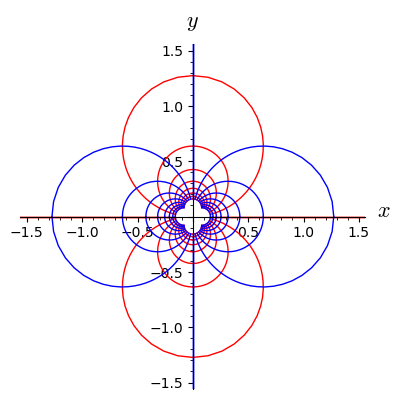

In [11]:
import itertools

plots = [stereo_sW.plot(
    stereo_n, 
    ranges={
        xp:[0, qx * 2 * pi],
        yp:[0, qy * 2 * pi]
    },
    color={xp:"red", yp:"blue"}
) for qx, qy in itertools.product([1, -1], [1, -1])]

show(sum(plots), xmin=-1.5, xmax=1.5, ymin=-1.5, ymax=1.5)

The easiest way to gain an intuition for what this plot is to image you are at the south pole watching points move along lines of constant $x'$ (red) and $y'$ (blue). The spherical nature of the manifold is reflected in that these curves are periodic.

## Spherical coordinates <a name="0-Spherical-coordinates"></a>
The standard spherical (polar) coordinates $(\theta, \phi)$ are defined on the open domain $A$ where

$$
A \subset W \subset \mathbb{S}^2,
$$

that is the complement of the origin meridian. The origin meridian is the half-circle defined by $y=0$ and $x \geq 0$:

In [12]:
A = W.open_subset(
    "A",
    coord_def={
        stereo_nW: (y != 0, x < 0),
        stereo_sW: (yp != 0, xp < 0)
    }
)

We obtain the restriction of the stereographic chart at the north pole to $A$ through:

In [13]:
stereo_nA = stereo_nW.restrict(A)
stereo_nA

Chart (A, (x, y))

Next we declare the spherical chart:

In [14]:
chartdef = r"theta:(0,pi):\theta phi:(0,2*pi):\phi"
spher.<theta,phi> = A.chart(chartdef)
spher

Chart (A, (theta, phi))

### Transition maps <a name="0-Transition-maps"></a>

Define the transition map:

In [15]:
spher2stereo_nA = spher.transition_map(
    stereo_nA,
    (
        sin(theta) * cos(phi) / (1 - cos(theta)),
        sin(theta) * sin(phi) / (1 - cos(theta))
    )
)
spher2stereo_nA.display()

x = -cos(phi)*sin(theta)/(cos(theta) - 1)
y = -sin(phi)*sin(theta)/(cos(theta) - 1)

And define the inverse:

In [16]:
spher2stereo_nA.set_inverse(
    2 * atan(1 / sqrt(x^2 + y^2)),
    atan2(-y, -x) + pi
)

spher2stereo_nA.inverse().display()

Check of the inverse coordinate transformation:
  theta == 2*arctan(sqrt(-cos(theta) + 1)/sqrt(cos(theta) + 1))  **failed**
  phi == pi + arctan2(sin(phi)*sin(theta)/(cos(theta) - 1), cos(phi)*sin(theta)/(cos(theta) - 1))  **failed**
  x == x  *passed*
  y == y  *passed*
NB: a failed report can reflect a mere lack of simplification.


theta = 2*arctan(1/sqrt(x^2 + y^2))
phi = pi + arctan2(-y, -x)

The transition map

$$
(A, (\theta, \phi)) \rightarrow (A, (x', y'))
$$

can be calculated through combination of

$$
(A, (\theta, \phi)) \rightarrow (A, (x, y))
$$

and

$$
(A, (x, y)) \rightarrow (A, (x', y'))
$$

which can be done is SageManifold with:

In [17]:
stereo_n2sA = stereo_n2s.restrict(A)

spher2stereo_s = stereo_n2sA * spher2stereo_nA

print(spher2stereo_s)
spher2stereo_s.display()

Change of coordinates from Chart (A, (theta, phi)) to Chart (A, (xp, yp))


xp = -(cos(phi)*cos(theta) - cos(phi))/sin(theta)
yp = -(cos(theta)*sin(phi) - sin(phi))/sin(theta)

The map
$$
(A, (x', y')) \rightarrow (A, (\theta, \phi)) 
$$
can be obtained in a similar way:

In [18]:
stereo_s2nA = stereo_n2s.inverse().restrict(A)

stereo_s2spher = spher2stereo_nA.inverse() * stereo_s2nA

print(stereo_s2spher)
stereo_s2spher.display()

Change of coordinates from Chart (A, (xp, yp)) to Chart (A, (theta, phi))


theta = 2*arctan(sqrt(xp^2 + yp^2))
phi = pi - arctan2(yp/(xp^2 + yp^2), -xp/(xp^2 + yp^2))

Our atlas now reflects all of these implicit charts:

In [19]:
S2.atlas()

[Chart (U, (x, y)),
 Chart (V, (xp, yp)),
 Chart (W, (x, y)),
 Chart (W, (xp, yp)),
 Chart (A, (x, y)),
 Chart (A, (xp, yp)),
 Chart (A, (theta, phi))]

### Plotting <a name="0-Plotting"></a>
We can plot the spherical chart in terms of the coordinates of the stereographic projection with:

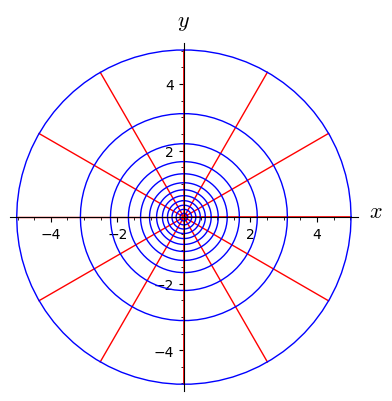

In [20]:
spher.plot(
    stereo_n, # choice of n and nW is arbitrary, as coordinates the same
    number_values=13,
    color={theta:"red", phi:"blue"},
    ranges={theta:(pi/8, pi)}
)

Or in the coordinate chart defined on $V$:

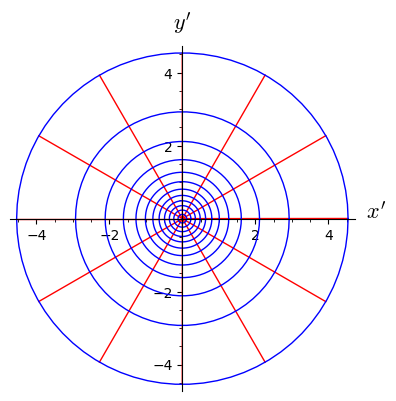

In [21]:
spher.plot(
    stereo_s,
    number_values=13,
    color={theta:"red", phi:"blue"},
    ranges={theta:(0.01, pi/1.16)}
)

*NB*: the limits for the south pole on $\theta$ are more tentative, due to the $(1 - \cos(\theta))$ in the denominator of the transition maps.

## Points on $\mathbb{S}^2$ <a name="0-Points-on-$\mathbb{S}^2$"></a>
Let us now declare two points on our sphere, namely the north and south pole. We declare these points as the point $(0,0)$ of their respective charts:

In [22]:
n_pole = V.point((0, 0), chart=stereo_s, name="N")
s_pole = U.point((0, 0), chart=stereo_n, name="S")

*NB:* the north pole is the origin of the coordinate chart of the open-subset not including the south pole. The notation of `stereo_s` and `stereo_n` may in hind-sight not have been an apt choice.

The above syntax in SageManifold is equivalent to:

In [23]:
n_pole = V((0, 0), name="N")
s_pole = U((0, 0), name="S")

leveraging that the default chart on $V$ is `stereo_s`.

In terms of the SageMath AST:

In [24]:
n_pole.parent(), s_pole.parent()

(Open subset V of the 2-dimensional differentiable manifold S^2,
 Open subset U of the 2-dimensional differentiable manifold S^2)

Indeed:

In [25]:
(
    n_pole in V,   # true
    n_pole in S2,  # true
    n_pole in U,   # false, excluded manifestly
    n_pole in A    # false, restricted by domain
)

(True, True, False, False)

By contrast, a point along the equator:

In [26]:
E = S2((0, 1), name="E") # default chart is stereo_n

E in A

True

And given the above is true, we may then project:

In [27]:
E.coord(spher)

(1/2*pi, 1/2*pi)

This is not possible for the north or south pole.

## Embedding $\mathbb{S}^2$ into $\mathbb{R}^3$ <a name="0-Embedding-$\mathbb{S}^2$-into-$\mathbb{R}^3$"></a>

We declare a 3-dimensional Euclidean space, using $(X, Y, Z)$ as the coordinates:

In [28]:
opts = dict(
    name="R^3", 
    latex_name=r"\mathbb{R}^3",
    metric_name="h"
)

R3.<X,Y,Z> = EuclideanSpace(**opts)

cart = R3.cartesian_coordinates()
cart

Chart (R^3, (X, Y, Z))

The embedding of $\mathbb{S}^2$ into $\mathbb{R}^3$ is defined using standard formulas relating stereographic coordinates to the common Cartesian. We are considering projections from the point $(0, 0, 1)$ (`n_pole`) or $(0,0,-1)$ (`s_pole`) to the equatorial plane defined by $Z=0$:

In [29]:
phi_map = S2.diff_map(
    R3,
    {
        (stereo_n, cart):
        [
            2 * x / (1 + x^2 + y^2),
            2 * y / (1 + x^2 + y^2),
            (x^2 + y^2 - 1) / (1 + x^2 + y^2)
        ],
        (stereo_s, cart):
        [
            2 * xp / (1 + xp^2 + yp^2),
            2 * yp / (1 + xp^2 + yp^2),
            (1 - xp^2 - yp^2) / (1 + xp^2 + yp^2)
        ]
    },
    name = "phi_map", latex_name=r"\Phi"
)

phi_map.display()

phi_map: S^2 --> R^3
on U: (x, y) |--> (X, Y, Z) = (2*x/(x^2 + y^2 + 1), 2*y/(x^2 + y^2 + 1), (x^2 + y^2 - 1)/(x^2 + y^2 + 1))
on V: (xp, yp) |--> (X, Y, Z) = (2*xp/(xp^2 + yp^2 + 1), 2*yp/(xp^2 + yp^2 + 1), -(xp^2 + yp^2 - 1)/(xp^2 + yp^2 + 1))

The parent of this map is the set of (homo)morphism from $\mathbb{S}^2$ to $\mathbb{R}^3$:

In [30]:
phi_map.parent()

Set of Morphisms from 2-dimensional differentiable manifold S^2 to Euclidean space R^3 in Category of smooth manifolds over Real Field with 53 bits of precision

Finding the coordinates of the north and south pole on our Euclidean manifold:

In [31]:
N1 = phi_map(n_pole)
S1 = phi_map(s_pole)

N1.coord(), S1.coord()

((0, 0, 1), (0, 0, -1))

Although $\Phi$ is defined in terms of the charts $(U, (x, y))$ and $(V, (x', y'))$, we may express the mapping in terms of the spherical coordinates we provided transition maps for.

To achieve this, we first need to calculate the mapping to $(A, (x,y))$:

In [32]:
phi_map.expr(stereo_nA)

(2*x/(x^2 + y^2 + 1), 2*y/(x^2 + y^2 + 1), (x^2 + y^2 - 1)/(x^2 + y^2 + 1))

Now we can ask SageManifold to express the map in terms of the spherical coordinates:

In [33]:
phi_map.expr(spher)

(cos(phi)*sin(theta), sin(phi)*sin(theta), cos(theta))

These expression are implicitly added to the map's definitions:

In [34]:
phi_map.display()

phi_map: S^2 --> R^3
on U: (x, y) |--> (X, Y, Z) = (2*x/(x^2 + y^2 + 1), 2*y/(x^2 + y^2 + 1), (x^2 + y^2 - 1)/(x^2 + y^2 + 1))
on V: (xp, yp) |--> (X, Y, Z) = (2*xp/(xp^2 + yp^2 + 1), 2*yp/(xp^2 + yp^2 + 1), -(xp^2 + yp^2 - 1)/(xp^2 + yp^2 + 1))
on A: (theta, phi) |--> (X, Y, Z) = (cos(phi)*sin(theta), sin(phi)*sin(theta), cos(theta))

### Plotting <a name="0-Plotting"></a>
We can draw the spherical coordinates with $\Phi$ onto the Cartesian coordinates in $\mathbb{R}^3$:

In [35]:
graph_spher = spher.plot(
    cart,
    mapping=phi_map,
    number_values=13,
    color={theta:"red", phi:"blue"}
)

graph_spher

Graphics3d Object

Similarly, we can use the mapping to project the stereographic coordinates:

In [36]:
graph_stereo_n = stereo_n.plot(
    cart,
    mapping=phi_map,
    number_values=27,
    color={x:"red", y:"blue"}
)

graph_stereo_s = stereo_s.plot(
    cart,
    mapping=phi_map,
    number_values=27,
    color={xp:"green", yp:"cyan"}
)

graph_stereo_s + graph_stereo_n

Graphics3d Object